In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# %reload_ext autoreload
# %autoreload 2

import numpy as np
from matplotlib import pyplot as plt

from vectran import data
from vectran.data.syndata.datasets import SyntheticHandcraftedDataset
from vectran.data.syndata.utils import renormalize as _normalize_probas
from vectran.data import graphics_primitives
from vectran.data.graphics_primitives import PrimitiveType

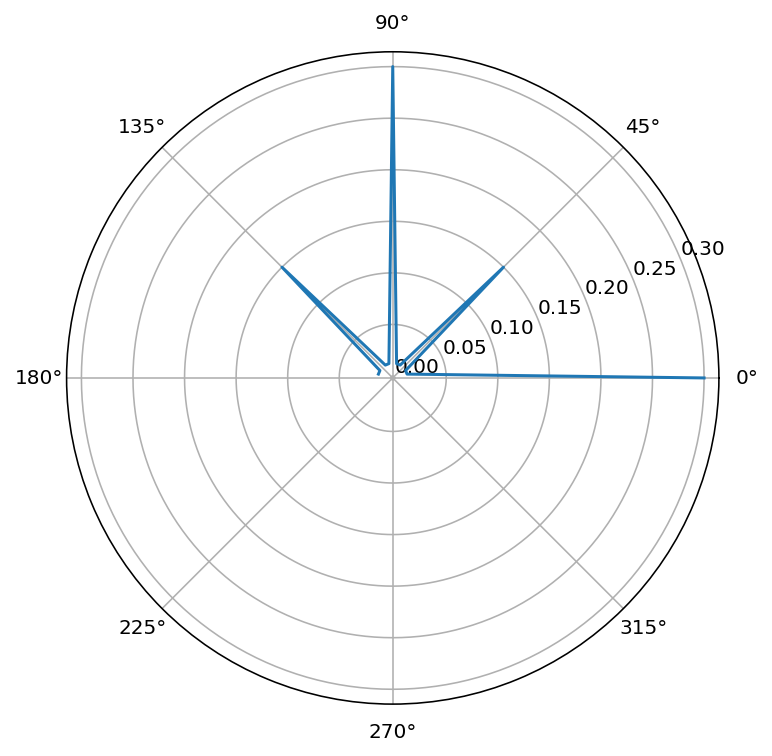

In [2]:
topologies_with_probas = _normalize_probas({
    'l': 1,
    'l-beam': 1,
    'l-outer': 1,
    't': 1,
    't-beam': 1,
    't-outer': 1,
    'x': 1,
    'x-beam': 1,
    'x-outer': 1,
})

strokes_probas = _normalize_probas({1: .45, 2: .45, 3: .1})

directions_probas = {}
for angle in np.linspace(0, np.pi, 13):
    if angle in [0, np.pi / 2]:                 # - horizontal, | vertical
        directions_probas[angle] = .30
    elif angle in [np.pi / 4, np.pi * 3 / 4]:   # /, \
        directions_probas[angle] = .15
    elif angle < np.pi:
        directions_probas[angle] = .1 / 8

directions_probas = _normalize_probas(directions_probas)

## def get_offset_angles():
##     rotations = [0, 90, 180, 270]
##     max_rot_deviation = 10
##     rotations += [base_rot + dev_rot * dev_sign for dev_rot in range(1, max_rot_deviation + 1, 1) for base_rot in (0, 90, 180, 270) for dev_sign in (1, -1)]
##     return rotations
def get_offset_angles():
    return range(0, 360, 4)
offset_directions_probas = _normalize_probas({np.deg2rad(angle): 1 for angle in get_offset_angles()})

# plot distribution of directions
directions, probas = zip(*directions_probas.items())

plt.figure(figsize=(6, 6))
plt.subplot(111, projection='polar')
plt.plot(directions, probas)
plt.show()

In [3]:
padding_factor = 2

patch_parameters = {
    'patch_width': 64,
    'patch_height': 64,
    'max_lines': 10,
    'max_curves': 0
}

syn_parameters = {
    'samples_n': 1000000,
    'border': 8,
    'min_directions': 1, 'max_directions': 2,   
    'min_primitives_gap': 2, 'max_primitives_gap': 10,
    'min_stroke_width': 1, 'max_stroke_width': 7,
    'min_stroke_length': max(patch_parameters['patch_width'], patch_parameters['patch_height']) * .90 * padding_factor,
    'max_stroke_length': np.sqrt(patch_parameters['patch_width']**2 + patch_parameters['patch_height']**2) * padding_factor,
    'primitives_endpoint_noise_sigma': 0.5,
    'primitives_direction_noise_sigma': np.pi / 270.,
    'directions_probas': directions_probas,
    'offset_directions_probas': offset_directions_probas,
    'strokes_probas': strokes_probas,
}

random_seed = 78

In [4]:
# make primitive_types and max_primitives dicts based on the parameters
primitive_types = []
max_primitives = {}
if patch_parameters['max_lines'] > 0:
    primitive_types.append(graphics_primitives.PrimitiveType.PT_LINE)
    max_primitives[graphics_primitives.PrimitiveType.PT_LINE] = patch_parameters['max_lines']
if patch_parameters['max_curves'] > 0:
    primitive_types.append(graphics_primitives.PrimitiveType.PT_BEZIER)
    max_primitives[graphics_primitives.PrimitiveType.PT_BEZIER] = patch_parameters['max_curves']


# initialize syndataset
np.random.seed(random_seed)
syn_dataset = SyntheticHandcraftedDataset(
    patch_size=(patch_parameters['patch_width'], patch_parameters['patch_width']), normalize_image=True,
    primitive_types=primitive_types, max_primitives=max_primitives, size=syn_parameters['samples_n'],
    topologies_with_probas=topologies_with_probas, **syn_parameters)

In [5]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from contrib.differentiable_rendering.sigmoids_renderer.renderer import Renderer
from utils import (
    SyntheticPatch, LinePerturbationPipe, LineRandomShift, LineClip,
    compute_pixel_coords, compute_pixel_density, get_pixel_coords_and_density, wrap_lines_into_numpy_batch,
    torch_to_synthetic_lines
)
from optimize import optimize_line_batch

from matplotlib import pyplot as plt
import numpy as np
import torch

torch.manual_seed(4)
np.random.seed(4)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
from crossing_refiner import CrossingRefinerFull
from torch import nn, optim

In [7]:
import warnings
warnings.filterwarnings("ignore")
data = [syn_dataset[i] for i in range(10000)]

In [8]:
for i, sample in enumerate(data):
    data[i]['raster'] = 1 - sample['raster']
    vectors = sample['vector'][PrimitiveType.PT_LINE]
    vectors = vectors[vectors.sum(axis=1) != 0][:, :5]
    data[i]['crossing_raster'] = SyntheticPatch.from_lines(vectors, default_line_rgba=(1., 1., 1., 0.5)).get_image()
    data[i]['crossing_raster'] /= np.max(sample['crossing_raster'])

In [55]:
from torch.utils.data import DataLoader
from tqdm import tqdm

DEVICE = 'cuda'

model = CrossingRefinerFull().to(DEVICE)
model.train(True)
bce = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([1.0]).to(DEVICE))
mse = torch.nn.MSELoss()
l1_loss = torch.nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

dataloader = DataLoader(data, 64, True)
for epoch in range(50):
    for batch in tqdm(dataloader):
        raster = batch['raster'].unsqueeze(dim=1).float().to(DEVICE)
        crossing_raster = batch['crossing_raster'].unsqueeze(dim=1).float().to(DEVICE)

        pred = model.forward(raster)
        loss = l1_loss(pred, crossing_raster) + 0.5 * bce(pred, crossing_raster)
        diff = crossing_raster - pred
#         loss += 0.1 * torch.mean(torch.abs(diff) * torch.relu(diff))
#         loss += torch.abs((torch.max(crossing_raster) - torch.min(crossing_raster)) - (torch.max(crossing_raster) - torch.min(crossing_raster)))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 157/157 [00:03<00:00, 43.03it/s]


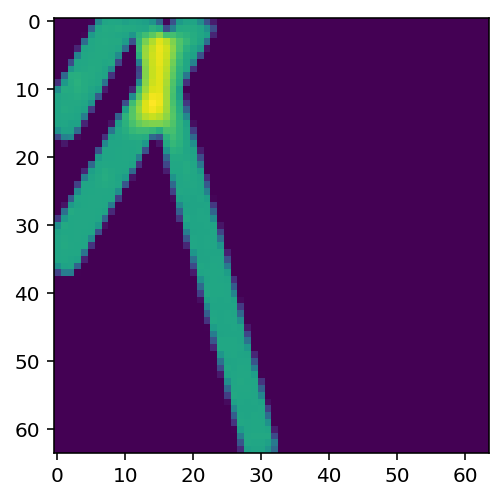

In [76]:
model.train(False)
raster = torch.from_numpy(data[87]['raster']).unsqueeze(dim=0).unsqueeze(dim=1).to(DEVICE)
pic = model.forward(raster).detach().cpu().numpy()
plt.imshow(pic[0][0])

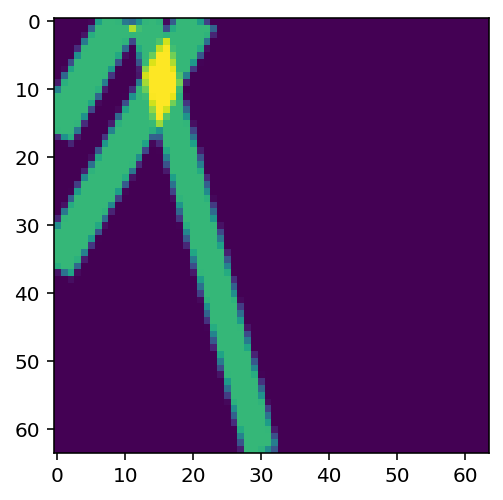

In [77]:
plt.imshow(data[87]['crossing_raster'])

In [315]:
from geomloss import SamplesLoss
from contrib.differentiable_rendering.sigmoids_renderer.renderer import Renderer


renderer = Renderer((64, 64), linecaps='butt', device='cuda', dtype=torch.float32)
samples_loss = SamplesLoss("sinkhorn", p=2, blur=.01)
bce_loss = torch.nn.MSELoss()


def make_sinkhorn_iters(line_batch, raster_coords, raster_masses, image, n_iters=300, coord_only_iters=300):
    line_batch.requires_grad_()
    image = torch.from_numpy(image).to(line_batch.get_device())
    image /= image.sum()
    optimizer = optim.SGD((line_batch, ), lr=0.5, momentum=0.9)
    
    masses_copy = None
    
    for step in range(n_iters):
        loss = 0.
        optimizer.zero_grad()
        
        vector_masses = renderer.render(line_batch)[0]
#         masses_copy = vector_masses.clone()
#         loss += bce_loss(vector_masses, image)
#         print(loss)
        vector_coords = vector_masses.nonzero().float()
        vector_masses = vector_masses.reshape(-1)
        vector_masses = vector_masses[vector_masses.nonzero()]
        vector_masses = (vector_masses / vector_masses.sum()).flatten()
        
        samples = samples_loss(vector_masses, vector_coords, raster_masses, raster_coords)
#         print(samples)
        loss += samples
#         print(loss)
        loss.backward()
        if step < coord_only_iters:
            line_batch.grad[:, :, 4] = 0.
        optimizer.step()
        
    return line_batch, masses_copy


RuntimeError: cannot perform reduction function min on tensor with no elements because the operation does not have an identity

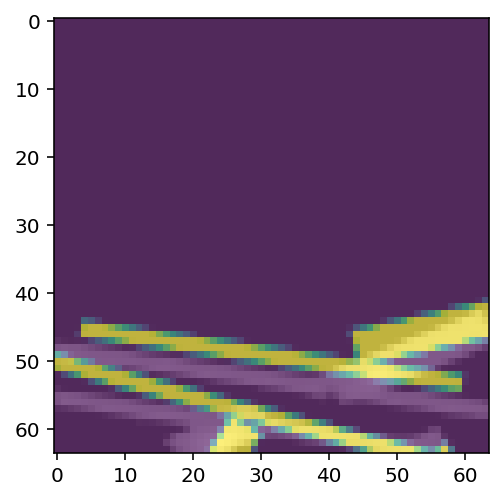

In [317]:
np.random.seed(211)
sample = syn_dataset[0]
perturber = LinePerturbationPipe(
    LineRandomShift((-6, 6), (0, 1)),
#     LineClip(0, 63, 0, 63)  # IMPORTANT
)
    
vectors = sample['vector'][PrimitiveType.PT_LINE]
vectors = vectors[vectors.sum(axis=1) != 0][:, :5]

perturbed_lines = perturber.transform(vectors)
perturbed_batch = wrap_lines_into_numpy_batch(perturbed_lines)
perturbed_batch = torch.from_numpy(perturbed_batch).to(DEVICE)

image = 1 - sample['raster']
image = torch.from_numpy(1 - sample['raster']).unsqueeze(dim=0).unsqueeze(dim=1)
image = model.forward(image.to(DEVICE)).detach().cpu().numpy()[0][0]
raster_coords, raster_masses = get_pixel_coords_and_density(image)

plt.imshow(image, cmap='gray', alpha=0.6)
plt.imshow(SyntheticPatch.from_lines(perturbed_lines).get_image(), alpha=0.6)

batch, masses = make_sinkhorn_iters(perturbed_batch, raster_coords, raster_masses, image)
batch = batch[0].detach().cpu().numpy()

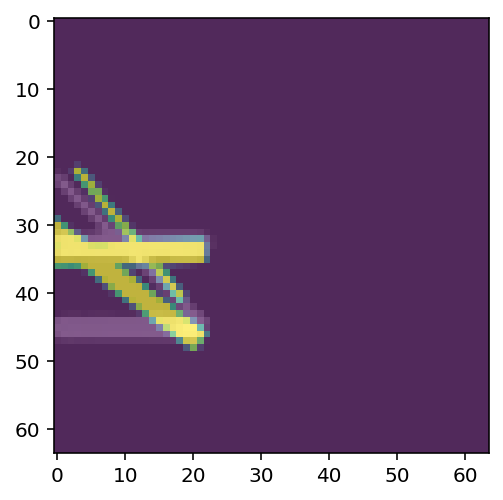

In [312]:
plt.imshow(image, cmap='gray', alpha=0.6)
plt.imshow(SyntheticPatch.from_lines(batch).get_image(), alpha=0.6)

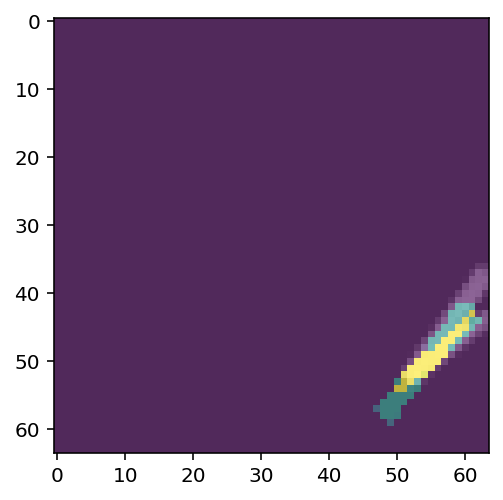

In [290]:
plt.imshow(image, cmap='gray', alpha=0.6)
plt.imshow(masses.detach().cpu().numpy(), alpha=0.6)

In [292]:
raster_masses

tensor([0.0040, 0.0042, 0.0042, 0.0115, 0.0099, 0.0007, 0.0107, 0.0117, 0.0119,
        0.0082, 0.0121, 0.0125, 0.0103, 0.0054, 0.0119, 0.0127, 0.0120, 0.0031,
        0.0024, 0.0118, 0.0126, 0.0127, 0.0073, 0.0099, 0.0121, 0.0131, 0.0093,
        0.0001, 0.0071, 0.0120, 0.0129, 0.0105, 0.0038, 0.0044, 0.0101, 0.0041,
        0.0120, 0.0127, 0.0115, 0.0077, 0.0084, 0.0116, 0.0113, 0.0014, 0.0112,
        0.0125, 0.0124, 0.0110, 0.0105, 0.0120, 0.0117, 0.0083, 0.0092, 0.0124,
        0.0126, 0.0127, 0.0127, 0.0126, 0.0124, 0.0057, 0.0011, 0.0063, 0.0120,
        0.0126, 0.0126, 0.0127, 0.0125, 0.0115, 0.0043, 0.0033, 0.0118, 0.0124,
        0.0126, 0.0126, 0.0126, 0.0103, 0.0024, 0.0005, 0.0106, 0.0123, 0.0126,
        0.0126, 0.0126, 0.0087, 0.0010, 0.0080, 0.0123, 0.0126, 0.0125, 0.0124,
        0.0066, 0.0050, 0.0124, 0.0126, 0.0125, 0.0118, 0.0043, 0.0088, 0.0125,
        0.0131, 0.0117, 0.0023, 0.0092, 0.0111, 0.0026, 0.0012],
       device='cuda:0')

In [293]:
raster_coords

tensor([[36., 62.],
        [36., 63.],
        [37., 61.],
        [37., 62.],
        [37., 63.],
        [38., 60.],
        [38., 61.],
        [38., 62.],
        [38., 63.],
        [39., 60.],
        [39., 61.],
        [39., 62.],
        [39., 63.],
        [40., 59.],
        [40., 60.],
        [40., 61.],
        [40., 62.],
        [40., 63.],
        [41., 58.],
        [41., 59.],
        [41., 60.],
        [41., 61.],
        [41., 62.],
        [42., 58.],
        [42., 59.],
        [42., 60.],
        [42., 61.],
        [42., 63.],
        [43., 57.],
        [43., 58.],
        [43., 59.],
        [43., 60.],
        [43., 61.],
        [43., 62.],
        [43., 63.],
        [44., 56.],
        [44., 57.],
        [44., 58.],
        [44., 59.],
        [44., 60.],
        [44., 61.],
        [44., 62.],
        [44., 63.],
        [45., 55.],
        [45., 56.],
        [45., 57.],
        [45., 58.],
        [45., 59.],
        [45., 60.],
        [45., 61.],


Yellow lines are perturbed/transported
Gray background lines are ground truth


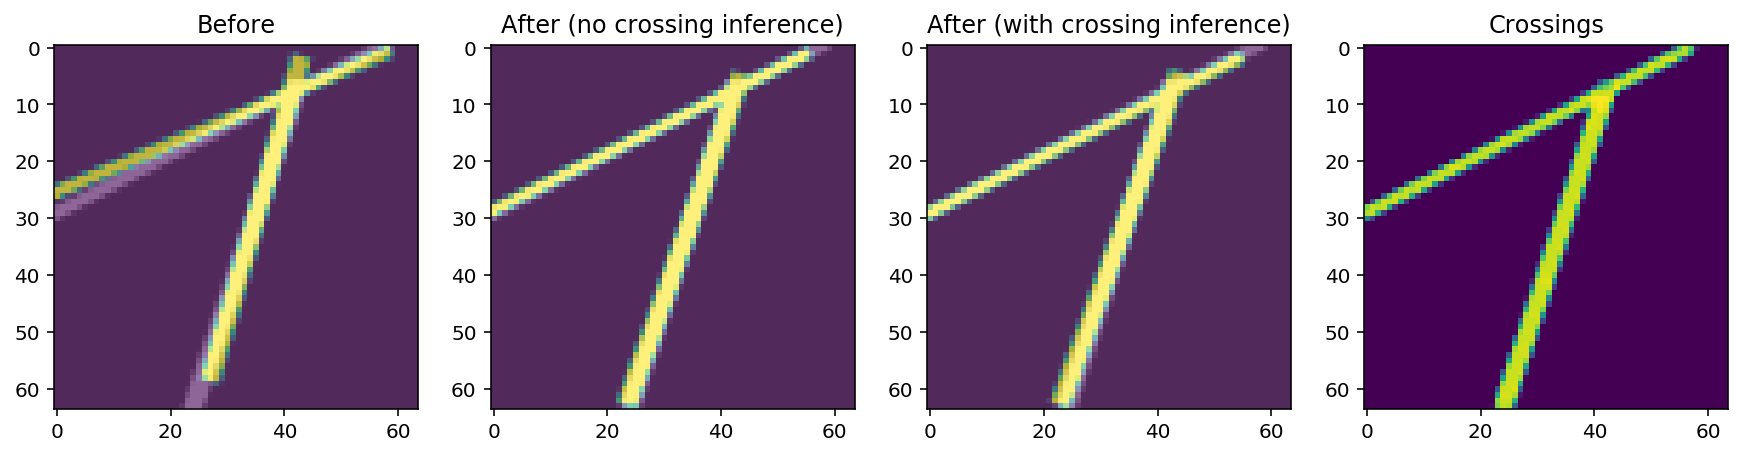

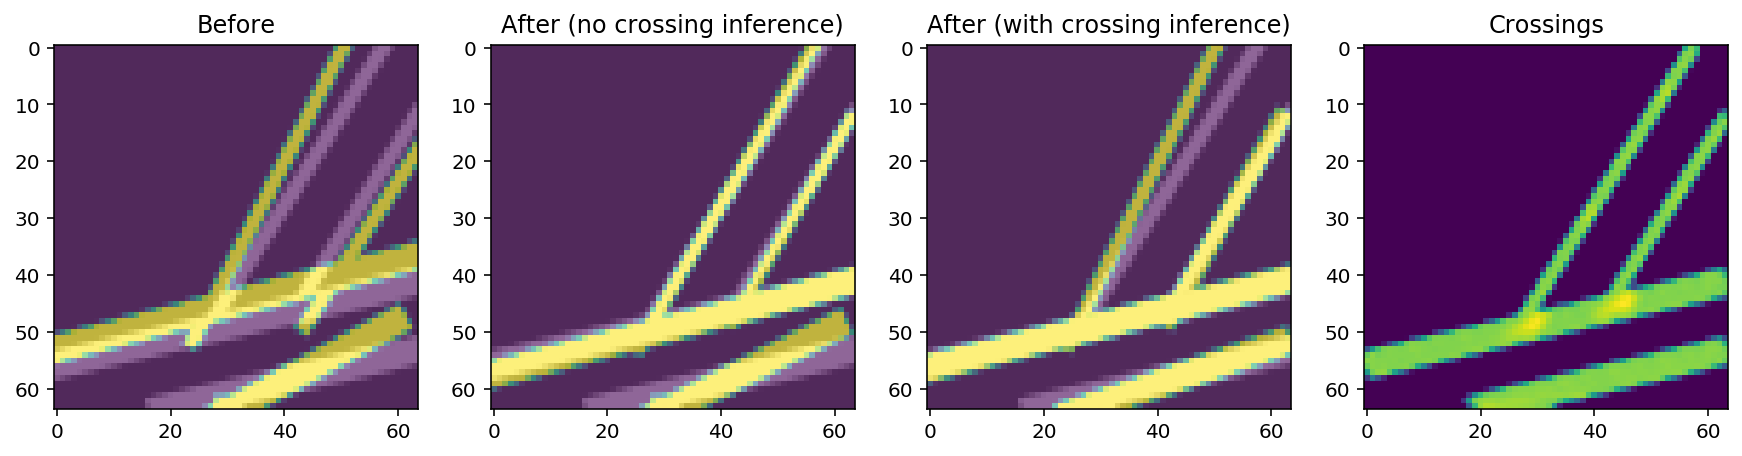

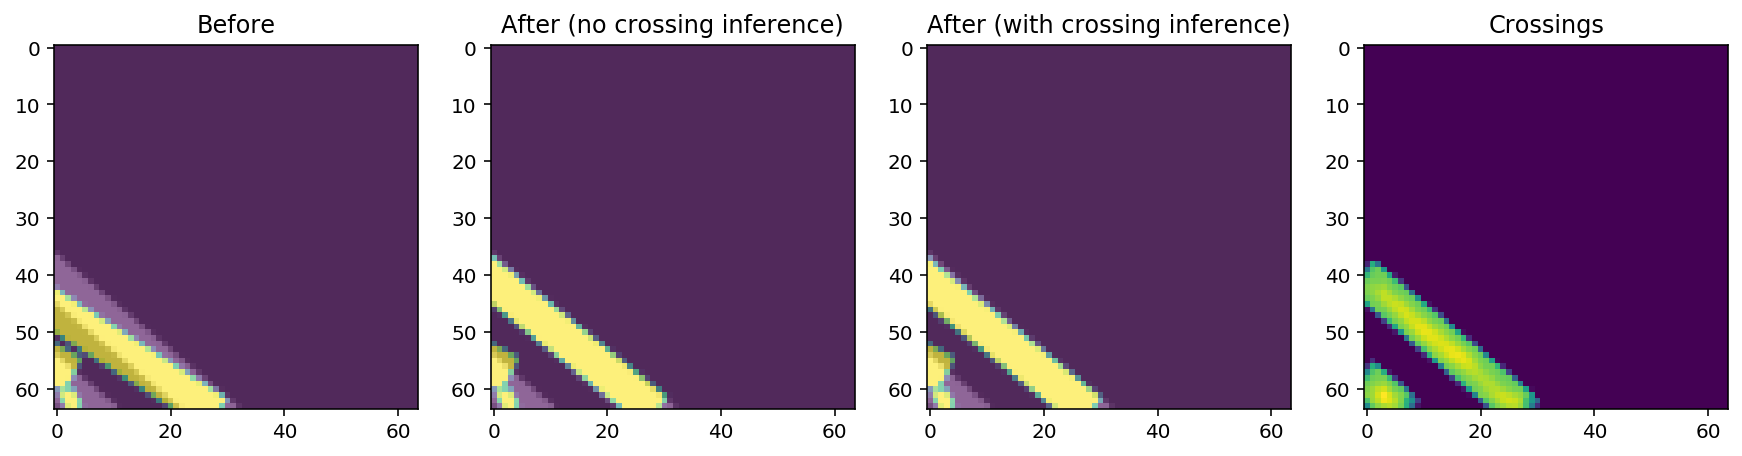

KeyboardInterrupt: 

In [82]:
np.random.seed(1)
perturber = LinePerturbationPipe(
    LineRandomShift((-6, 6), (0, 1)),
#     LineClip(0, 63, 0, 63)  # IMPORTANT
)

renderer = Renderer((64, 64), dtype=torch.float32, device=DEVICE)

print('Yellow lines are perturbed/transported')
print('Gray background lines are ground truth')

model.train(False)

for random_seed in range(100, 200):
    sample = syn_dataset[random_seed]
    
    vectors = sample['vector'][PrimitiveType.PT_LINE]
    vectors = vectors[vectors.sum(axis=1) != 0][:, :5]

    perturbed_lines = perturber.transform(vectors)
    perturbed_batch = wrap_lines_into_numpy_batch(perturbed_lines)
    image = 1 - sample['raster']
    raster_coords, raster_masses = get_pixel_coords_and_density(image)
    grads = []
    optimized, steps = optimize_line_batch(torch.from_numpy(perturbed_batch).to(DEVICE),
                                           raster_coords, raster_masses, return_batches_by_step=True, image=image, pos_weight=2.0, sinkhorn_steps=320,
                                           lr=0.4, n_iters=350, coord_only_steps=240, width_lr=0.1, ot=1., mse=0., bce=0., l1=1., grads=grads)
    optimized = optimized.detach().cpu()
    
    image = torch.from_numpy(1 - sample['raster']).unsqueeze(dim=0).unsqueeze(dim=1)
    image = model.forward(image.to(DEVICE)).detach().cpu().numpy()[0][0]
    raster_coords, raster_masses = get_pixel_coords_and_density(image)
    grads_cross = []
    optimized_cross, steps_cross = optimize_line_batch(torch.from_numpy(perturbed_batch).to(DEVICE),
                                                       raster_coords, raster_masses, return_batches_by_step=True, image=image, pos_weight=2.0, sinkhorn_steps=320,
                                                       lr=0.4, n_iters=350, coord_only_steps=240, width_lr=0.1, ot=1., mse=0., bce=0., grads=grads_cross)
    optimized_cross = optimized_cross.detach().cpu()
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.title('Before')
    plt.imshow(1 - sample['raster'], cmap='gray', alpha=0.6)
    plt.imshow(SyntheticPatch.from_lines(perturbed_lines).get_image(), alpha=0.6)
    plt.subplot(1, 4, 2)
    plt.title('After (no crossing inference)')
    plt.imshow(1 - sample['raster'], cmap='gray', alpha=0.6)
    plt.imshow(SyntheticPatch.from_lines(torch_to_synthetic_lines(optimized[0])).get_image(), alpha=0.6)
    plt.subplot(1, 4, 3)
    plt.title('After (with crossing inference)')
    plt.imshow(1 - sample['raster'], cmap='gray', alpha=0.6)
    plt.imshow(SyntheticPatch.from_lines(torch_to_synthetic_lines(optimized_cross[0])).get_image(), alpha=0.6)
    plt.subplot(1, 4, 4)
    plt.title('Crossings')
    plt.imshow(image)
#     plt.subplot(1, 5, 4)
#     plt.title('L2 norm of grads (crossings)')
#     grad_norms = []
#     for grad in grads_cross:
#         grad_norms.append(torch.sqrt((grad * grad).sum()))
#     plt.plot(grad_norms)
    plt.show()

##### 